In [163]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

In [164]:
db_filename = 'dinofunworld.db'
conn = sqlite3.connect(db_filename)
c = conn.cursor()

visitorID,165316,296394,404385,448990,1835254
visitorID,,,,,
165316,0,30,38,30,28
296394,30,0,37,0,19
404385,38,37,0,37,38
448990,30,0,37,0,19
1835254,28,19,38,19,0


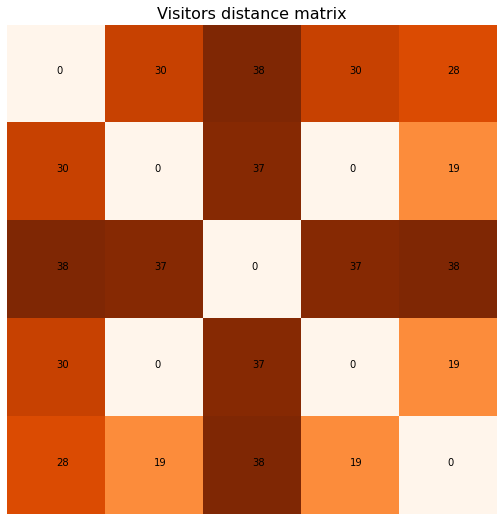

In [195]:
#Question 1 
#1.按要求从数据表中读取5位用户的访问序列
#2.清洗数据，因为每5分钟一个数据点，因此数据中会存在很多重复的数据，将这些相邻的重复的数据合并为一个景点ID，形成参观路径
#3.构建一个5×5的矩阵表，X和Y都是5位用户，以用来存储用户与用户的距离
#4.计算用户距离并放入对应的矩阵中，计算逻辑是根据参观路径上是否相同，每多一个不同就+1

c.execute("SELECT visitorID,sequence from sequences WHERE visitorID in(165316,1835254,296394,404385,448990)")
rs = c.fetchall()
data = pd.DataFrame.from_records(rs, columns=['visitorID', 'sequence'])
#清洗数据，将序列数据清洗为各个景点唯一的路径数据
for idx,item in data.iterrows():
    seq =[e for e in item['sequence'].split("-") if e!='0']
    path = []
    for e in seq:
        if e not in path:
            path.append(e)
    data.loc[idx]=[item['visitorID'],path]

#构建距离5×5的距离矩阵，根据参观路径上的点是否相同计算距离
data_arr = np.arange(25).reshape(5,5)
matrix = pd.DataFrame(data_arr,index=data['visitorID'],columns=data['visitorID'])
for _,v1 in data.iterrows():
    for _,v2 in data.iterrows():
        vid1 = int(v1['visitorID'])
        vid2 = int(v2['visitorID'])
        matrix[vid1][vid2] = 0
        seq_len = len(v1['sequence'])
        if seq_len < len(v2['sequence']):
            seq_len = len(v2['sequence'])
        for idx in range(seq_len):
            if idx<len(v1['sequence']) and idx <len(v2['sequence']):
                if v1['sequence'][idx] !=v2['sequence'][idx]:
                    matrix[vid1][vid2]  += 1
            else:
                matrix[vid1][vid2]  += 1
plt.figure(figsize=(15,9))
plt.title("Visitors distance matrix",fontsize=16)
plt.imshow(matrix,interpolation ='nearest',cmap=plt.cm.Oranges)
plt.axis('off')
iters = np.reshape([[[i,j] for j in range(5)] for i in range(5)],(matrix.size,2))
for i, j in iters:
    plt.text(j, i, data_arr[i][j])   #显示对应的数字
# plt.show()
matrix

,min,max,avg
ride,,,
Wrightiraptor Mountain,3,788,425
Galactosaurus Rage,10,893,435
Auvilotops Express,28,834,434
TerrorSaur,31,571,327
Wendisaurus Chase,32,743,362
Keimosaurus Big Spin,39,871,437
Firefall,30,614,372
Atmosfear,5,1046,630
North Line,7,204,85


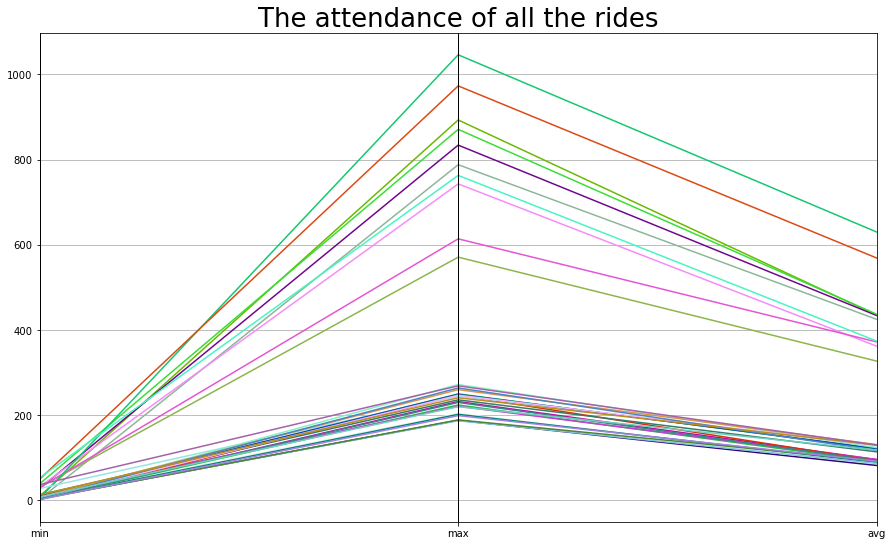

In [196]:
#Question 2
#1.根据题目要求先统计出所有的游乐项目并放入表中，同时在表中增加最小、最大和平均列，分别代表最小参入量、最大参入量、平均参入量
#2.根据Checkin记录按小时统计最大参入量、最下参入量、和平均参入量，并且将统计结果放入第1步中的数据表中
#3.利用柱状图显示结果
c.execute("SELECT Name FROM attraction WHERE Category like '%Rides%'")
rs = c.fetchall()
ridesDF = pd.DataFrame.from_records(rs, index='ride',columns=['ride'])
ridesDF['min'] = 0
ridesDF['max'] = 0
ridesDF['avg'] = 0
c.execute("SELECT attraction.Name,cast(substr(checkin.timestamp,9,2) as int) as Day,cast(substr(checkin.timestamp,12,2) as int) as Hour,count(attraction.AttractionID) as times from checkin,attraction where attraction.AttractionID=checkin.attraction and attraction.Category like '%Rides%' GROUP BY Name,Day,Hour")
rs = c.fetchall()
attrDF = pd.DataFrame.from_records(rs,columns=['Name','Day','Hour','Times'])
for ride,item in ridesDF.iterrows():
    ddf = attrDF[attrDF['Name']==ride]
    item['min']=ddf['Times'].min()
    item['max']=ddf['Times'].max()
    item['avg']=ddf['Times'].mean()

pwidth =0.1
plt.figure(figsize=(15,9))
plt.title("The attendance of all the rides",fontsize=26)
parallelDF = ridesDF.reset_index(drop=False)
parallel_coordinates(parallelDF,"ride")
plt.gca().legend_.remove()
ridesDF
# plt.show()


array([[<AxesSubplot:xlabel='min', ylabel='min'>,
        <AxesSubplot:xlabel='max', ylabel='min'>,
        <AxesSubplot:xlabel='avg', ylabel='min'>],
       [<AxesSubplot:xlabel='min', ylabel='max'>,
        <AxesSubplot:xlabel='max', ylabel='max'>,
        <AxesSubplot:xlabel='avg', ylabel='max'>],
       [<AxesSubplot:xlabel='min', ylabel='avg'>,
        <AxesSubplot:xlabel='max', ylabel='avg'>,
        <AxesSubplot:xlabel='avg', ylabel='avg'>]], dtype=object)

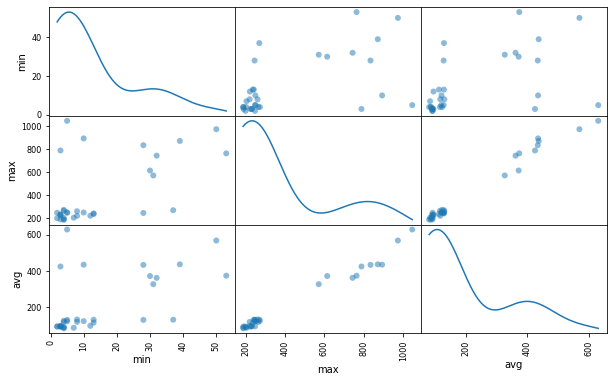

In [198]:
#Question 3 使用第2个问题中的数据向量生成三点矩阵图，最大参入量、最小参入量、平均参入量分别代表散点矩阵图中的三个属性，在统中分别可以看出平均值与最小值、平均值与最大值、以及最大值与最小值的分布特点。

pd.plotting.scatter_matrix(ridesDF,figsize=(10,6),marker = 'o',diagonal='kde',alpha = 0.5,range_padding=0.1)